# Notes on Superhydrophobic Nanopartical Coatings Solar Panel Processing Code and Analysis

The goal of this project put forth by Dr. Amanda Barker at CRREL is to inform the Army of the performace and applicability of commercially-available solar panel coatings. We are looking to study the main effects of these coatings. We suppose that the coatings minimize the effect of ice, dirt, and most importantly snow accumulation during extreme weather events, in turn we hope the panels will perform better and be easier to maintain over their lifetime.

## Methods
This project tested 3 different solar panel coatings. Coating 1 was described as a 'proprietary compound'. Coating 2 is a silicon dioxide nanoparticle-based proprietary substance. Coating 3 is a titanium dioxide nanoparticle-base proprietary substance. Site information such as angle of array, solar irradiance, albedo, global horizontal irradiance, air temperature, panel temperature, daily time-lapse video, and wind velocity were also obtained. 
...


## Time-lapse Processing Code

#### Introduction 
We expect snow cover to be a key predictor in the performance of each panel. To measure snow cover daily time-lapse videos were recorded. In the processing of this data there are some key factors to keep in mind. The time series time step of the data is important, we want to be able to capture the signal that is snow cover while at the same time ensuring that our analysis adequately deals with the possibility of autocorrelation in our data. 

#### Dependencies 
For a majority of this project we will be using python, and more specifically cv2 the python wrapper for OpenCV. 

In [1]:
import numpy as np
import pandas as pd
import os 
from PIL import Image
import cv2 # For Image Processing 
from matplotlib import pyplot as plt
import copy

In [4]:
            #### Code for frame processing. 
                # Crop the image into separate. 
                    # Either all panels or separate the panels as well.
                # Binarize the image with otsu
                # Snowcover is fraction of white pixels 
                # Pull timestamp from frame
                # Add new data to Pandas Datafame.

# https://www.geeksforgeeks.org/text-detection-and-extraction-using-opencv-and-ocr/ for pulling timestamp


def ImageProcess(img):







    
    

   ## # Applying the threshold
   ## threshImage = copy.deepcopy(img)
   ## ret, thresh = cv2.threshold(threshImage,0,255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)
   ## 
   ## # Creating the masks
   ## mask_fore = copy.deepcopy(img)
   ## mask_fore = np.where((img).astype(np.uint8) > ret, 0, 255)  
   ## image_fore = Image.fromarray((mask_fore).astype(np.uint8))
   ## os.chdir(str(path+'/Foreground_Masks'))
   ## image_fore.save(str(i),"JPEG") 






Empty DataFrame
Columns: [SnowCover, TimeStamp]
Index: []


In [5]:
#### Full Script For Segmentation and SnowCover Data Extraction 
SnowCover = pd.DataFrame(columns = ['TimeStamp', 'SnowCover'])

path = "C:\Users\Amanda Barker\Desktop\Stefano's Work\CRREL Solar Panel Project\TestTimeLapse" ##Supply Full Path to TimeLapse directory

#### Directory Management
os.chdir(path) #Change the working directory to the TimeLapse directory

TimeLapseList = [] #Pull the current list of files in image directory
for file in os.listdir(path):
    if file.endswith(".mp4"): # Herbarium Sheets are in jpg format
        TimeLapseList.append(file)


for i in TimeLapseList:
    os.chdir(path) # We have to set the path everytime since cv2 can't handle relative paths without it.
    currentVideo = cv2.VideoCapture(i, cv2.IMREAD_GRAYSCALE) # Reading in the current TimeLapse Video
    success, img = currentVideo.read()
    fno = 0
    while success:
        if fno % sample_rate == 0:
            ImageProcess(img)
        # read next frame
        success, img = cap.read()


IndentationError: expected an indented block (3307992751.py, line 31)

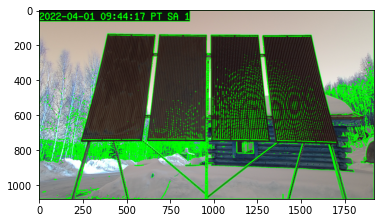

In [7]:
path = r'C:\Users\Amanda Barker\Desktop\Stefano\CRREL Solar Panel Project\TestTimeLapse' ##Supply Full Path to TimeLapse directory
os.chdir(path) # We have to set the path everytime since cv2 can't handle relative paths without it.
img = cv2.imread('TestImage2.png') # Reading in the current image
plt.imshow(img)
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
_, thresh = cv2.threshold(gray, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
plt.imshow(thresh)
contours, hiers = cv2.findContours(thresh, cv2.RETR_TREE, cv2.CHAIN_APPROX_NONE) # [-2:] indexing takes return value before last (due to OpenCV compatibility issues).
image_copy = img.copy()

cv2.drawContours(image=image_copy, contours=contours, contourIdx=-1, color=(0, 255, 0), thickness=2, lineType=cv2.LINE_AA)

plt.imshow(image_copy)

ValueError: zero-size array to reduction operation minimum which has no identity

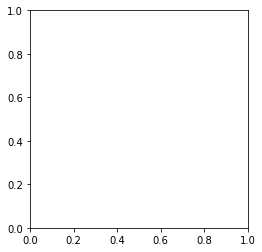

In [3]:
# Find contours and hierarchy, use RETR_TREE for creating a tree of contours within contours
cnts, hiers = cv2.findContours(thresh, cv2.RETR_TREE, cv2.CHAIN_APPROX_NONE)[-2:]  # [-2:] indexing takes return value before last (due to OpenCV compatibility issues).

# https://docs.opencv.org/master/d9/d8b/tutorial_py_contours_hierarchy.html
# Hierarchy Representation in OpenCV
# So each contour has its own information regarding what hierarchy it is, who is its child, who is its parent etc. 
# OpenCV represents it as an array of four values : [Next, Previous, First_Child, Parent]
parent = hiers[0, :, 3]

# Find parent contour with the maximum number of child contours
# Use np.bincount for counting the number of instances of each parent value.
# https://docs.scipy.org/doc/numpy/reference/generated/numpy.bincount.html#numpy.bincount
hist = np.bincount(np.maximum(parent, 0))
max_n_childs_idx = hist.argmax()

# Get the contour with the maximum child contours
c = cnts[max_n_childs_idx]

# Get bounding rectangle
x, y, w, h = cv2.boundingRect(c)

# Crop the bounding rectangle out of img
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

# Convert to binary image (after cropping) and invert polarity
_, thresh = cv2.threshold(gray, 0, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)

#cv2.imshow('thresh', thresh);cv2.waitKey(0);cv2.destroyAllWindows()

# Find connected components (clusters)
nlabel,labels,stats,centroids = cv2.connectedComponentsWithStats(thresh, connectivity=8)

# Delete large, small, tall and wide clusters - not letters for sure
max_area = 2000
min_area = 10
max_width = 100
max_height = 100
for i in range(1, nlabel):
    if (stats[i, cv2.CC_STAT_AREA] > max_area) or \
       (stats[i, cv2.CC_STAT_AREA] < min_area) or \
       (stats[i, cv2.CC_STAT_WIDTH] > max_width) or \
       (stats[i, cv2.CC_STAT_HEIGHT] > max_height):
        thresh[labels == i] = 0

#cv2.imshow('thresh', thresh);cv2.waitKey(0);cv2.destroyAllWindows()

# Use "closing" morphological operation for uniting text area
thresh = cv2.morphologyEx(thresh, cv2.MORPH_CLOSE, np.ones((50, 50)))

# Find contours once more
cnts = cv2.findContours(thresh, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)[-2]

# Get contour with maximum area
c = max(cnts, key=cv2.contourArea)

# Get bounding rectangle
x, y, w, h = cv2.boundingRect(c)

# Crop the bounding rectangle out of img (leave some margins)
out = img[y-5:y+h+5, x-5:x+w+5]

plt.imshow(out)